# Deep Learning image segmentation (horizon segmentation)
* Summited by: Md Ether Deowan
* Subbmited To: Arnaud Pietrosemoli (Ingénieur R&D en robotique)

# Exercise instructions
1.  You must answer the questions at the beginning of each paragraph  
2.  You must complete the code between #...#
3.  You must explain in comments the lines of code that you produce
4.  You can help and ask for help from others but you must indicate the person who helped you

# Références
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/utils.py



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import os

project_path = "/kaggle/working/"
checkpoint_subdir = "Save"
CHECKPOINT_PATH = os.path.join(project_path, checkpoint_subdir, "my_checkpoint.pth.tar")
PLOT_PATH = os.path.join(project_path, checkpoint_subdir, "Accuracy")
PLOT_VAL_PATH = os.path.join(project_path, checkpoint_subdir, "validation")

# Create directories if they don't exist
os.makedirs(os.path.join(project_path, checkpoint_subdir), exist_ok=True)
os.makedirs(PLOT_PATH, exist_ok=True)
os.makedirs(PLOT_VAL_PATH, exist_ok=True)

In [2]:
import os
project_path = "/kaggle/working/Save"
data_set_path = "/kaggle/input/dl-assignment-data"
TRAIN_IMG_DIR = os.path.join(data_set_path,"train_frames/train_frames/train")
TRAIN_MASK_DIR = os.path.join(data_set_path,"train_masks/train_masks/train")
VAL_IMG_DIR = os.path.join(data_set_path,"val_frames/val_frames/val")
VAL_MASK_DIR = os.path.join(data_set_path,"val_masks/val_masks/val")
CHECKPOINT_PATH = os.path.join(project_path,"/kaggle/working/Save/my_checkpoint.pth.tar")
PLOT_PATH = os.path.join(project_path,"/kaggle/working/Save/Accuracy")
PLOT_VAL_PATH = os.path.join(project_path,"/kaggle/working/Save/validation")

# Dataset
https://research.aimultiple.com/datasets-for-ml/

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pdb
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader


## Dataset Class
Questions:
1. Explain what the get_item function is for and how it is called in training mechanism?
2. why do we have to divide mask by 255?


# **Answer**
1. The __getitem__ method is a crucial component of any class that inherits from PyTorch's Dataset class. It's purpose is to:

* Retrieve a Single Item: For a given index, __getitem__ fetches a single data point (in this case, an image and its corresponding mask) from the dataset.
* Preprocessing: It applies any necessary preprocessing or transformations to the data before it's fed into the model. This can include resizing images, normalization, data augmentation, etc.

2. Dividing the Mask by 255
* Improves Training Stability: Smaller, normalized values often lead to more stable and faster convergence during training.
* Maintains Consistency: Many pre-trained models and libraries assume input data is normalized, so it's good practice to follow this standard.
Dividing the mask by 255 scales its values down to the [0, 1] range, aligning with these norms.

In [4]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class HorizonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        # Initialize the dataset with image and mask directories and an optional transform
        self.image_dir = image_dir  # Directory containing images
        self.mask_dir = mask_dir    # Directory containing masks
        self.transform = transform  # Optional data transformation function
        self.images = os.listdir(image_dir)  # List of image file names in the directory

    def __len__(self):
        # Return the total number of samples in the dataset (equal to the number of images)
        return len(self.images)

    def __getitem__(self, index):
        # Retrieve and preprocess a single data sample specified by the index
        
        # Get the file paths for the corresponding image and mask
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        
        # Open and convert the image to RGB format (3 channels)
        image = Image.open(img_path).convert("RGB") #TODO
        image = np.array(image)  # Convert the image to a NumPy array
        
        # Open and convert the mask to grayscale (1 channel)
        mask = Image.open(mask_path).convert("L") #TODO
        mask = np.array(mask, dtype=np.float32)  # Convert the mask to a NumPy array
        
        # Normalize the mask values to the range [0, 1]
        mask = mask / 255.0

        # Apply data augmentation if a transform is provided
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask) #TODO
            image = augmentations["image"]
            mask = augmentations["mask"]

        # Return the preprocessed image and mask as a tuple
        return image, mask


## Loader definition
Questions:
1. Explain what the data loader is for?

# Answer:
The primary purpose of a data loader is to provide an iterable interface for accessing the dataset, typically in the form of mini-batches, so that the model can be trained on small chunks of data at a time.

Here I can describe the implementation of the data loader for my image segmentation task. Here's a detailed breakdown of what the code is doing:

1. **Creating Training and Validation Datasets**:
   - Two datasets are created, one for training and one for validation. These datasets are instances of a custom class named `HorizonDataset`.
   - The `HorizonDataset` class is responsible for loading and preprocessing image data along with their corresponding masks. It applies data transformations defined by `train_transform` and `val_transform` to augment and preprocess the data.

2. **Training Data Loader**:
   - For the training dataset, a `DataLoader` object is created. This loader will provide mini-batches of training data during the training process.
   - The `batch_size` parameter specifies the number of samples in each mini-batch.
   - `shuffle=True` is set to shuffle the training data randomly before each epoch. Shuffling is crucial for training because it ensures that the model doesn't see the data in a fixed order, which can help in better generalization.
   - `num_workers` and `pin_memory` are optional parameters used to improve data loading efficiency when using GPU acceleration. `num_workers` specifies the number of CPU processes to use for loading data, and `pin_memory` can speed up data transfer to GPU memory.

3. **Validation Data Loader**:
   - Similarly, a `DataLoader` object is created for the validation dataset with similar parameters but with `shuffle=False`. Validation data doesn't need to be shuffled since its order doesn't affect the evaluation of the model.

4. **Returning Data Loaders**:
   - The function returns a tuple containing the training data loader and the validation data loader.

In summary, the data loader's primary role is to organize and manage the training and validation data, load it efficiently in mini-batches, apply data transformations, and optionally shuffle the training data. It plays a vital role in enabling the training process of machine learning models by making it feasible to work with large datasets effectively.

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform = A.Compose([
    # Add your desired transformations here
    A.Resize(256, 256),  # Example transformation
    ToTensorV2()
])

# Initialize your dataset
train_dataset = HorizonDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Test DataLoader
for images, masks in train_loader:
    print("Images batch shape:", images.shape)
    print("Masks batch shape:", masks.shape)
    break  # Only show the first batch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Images batch shape: torch.Size([4, 3, 256, 256])
Masks batch shape: torch.Size([4, 256, 256])


In [6]:
# The data loader allows you to iterate over the dataset.
# Each iteration below returns a batch of train_features and train_labels
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    """
    Create data loaders for the training and validation datasets.

    Parameters:
    - train_dir (str): Directory containing training images.
    - train_maskdir (str): Directory containing training masks.
    - val_dir (str): Directory containing validation images.
    - val_maskdir (str): Directory containing validation masks.
    - batch_size (int): Number of samples per batch to load.
    - train_transform (callable): Transformations to apply on training data.
    - val_transform (callable): Transformations to apply on validation data.
    - num_workers (int): Number of subprocesses to use for data loading.
    - pin_memory (bool): If True, the data loader will copy Tensors into CUDA pinned memory.

    Returns:
    - tuple: A tuple containing the training and validation data loaders.
    """

    # Create the training dataset using the specified directory and transformations.
    train_ds = HorizonDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    # Shuffle the training data to ensure random distribution, which helps in better generalization.
    # Shuffling is not required for the validation set.
    train_loader = DataLoader( #TODO
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )
    
    # Create the validation dataset.
    val_ds = HorizonDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    # No need to shuffle the validation data, as the order does not affect model evaluation.
    val_loader =  DataLoader( #TODO
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader


# Model definition
https://www.pinecone.io/learn/batch-layer-normalization/

https://medium.com/data-science-365/batch-normalization-explained-in-plain-english-3436014f9e52

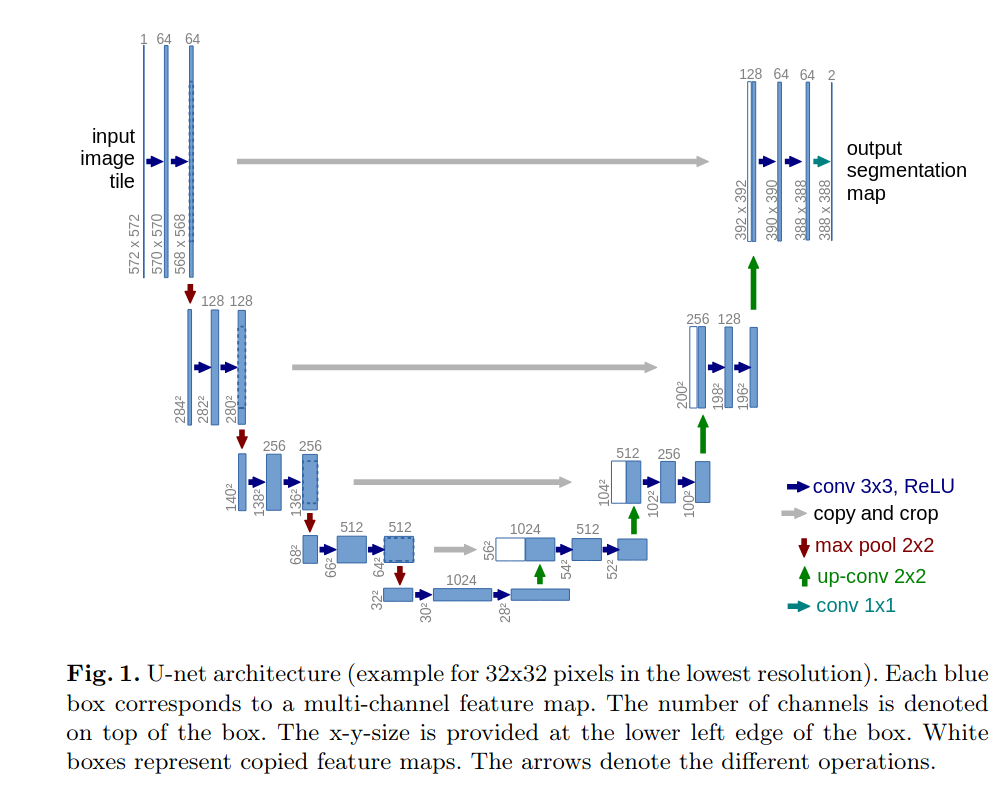

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# explain the line of code below
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Code explanations:
The line of code you provided is a conditional statement that determines the value of the `DEVICE` variable based on whether a GPU (CUDA) is available or not. Let's break down this line step by step:

1. `torch.cuda.is_available()`: This is a function call provided by the PyTorch library. It checks whether a GPU (CUDA-compatible device) is available on the system where the code is running. If a GPU is available, it returns `True`; otherwise, it returns `False`.

2. `DEVICE = "cuda" if torch.cuda.is_available() else "cpu"`: This is a conditional statement that sets the value of the `DEVICE` variable based on the result of `torch.cuda.is_available()`.

   - If a GPU is available (`torch.cuda.is_available()` is `True`), then `DEVICE` is assigned the string `"cuda"`, indicating that the code should use the GPU for computations.
   - If no GPU is available (`torch.cuda.is_available()` is `False`), then `DEVICE` is assigned the string `"cpu"`, indicating that the code should use the CPU for computations.


## Double convolution
Questions:
1. From the network diagram above, code an elementary brick composed of a convolution layer.Do the same but limiting to a single convolution layer.

In [8]:
 #Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d ->  ReLU#
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        # Define a sequential block of two consecutive convolutional layers with associated operations.
        self.conv = nn.Sequential(
            #TODO
            # First Convolutional Layer:
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            # Parameters:
            # - in_channels: Number of input channels to the layer.
            # - out_channels: Number of output channels (the depth of the feature maps).
            # - kernel_size: Size of the convolutional kernel (3x3 in this case).
            # - stride: Stride for the convolution operation (1 in this case).
            # - padding: Padding added to the input to maintain spatial dimensions (1 pixel on all sides).
            # - bias: Whether to include bias terms (set to False).

            # Batch Normalization Layer:
            nn.BatchNorm2d(out_channels),
            # Batch normalization helps stabilize training by normalizing the activations.
            # - out_channels: The number of channels of the feature maps to normalize.

            # Rectified Linear Unit (ReLU) Activation Function:
            nn.ReLU(inplace=True),
            # ReLU is used to introduce non-linearity.
            # - inplace=True: It means that the output is computed in-place, which saves memory.

            # Second Convolutional Layer (Similar to the first one):
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            # This convolutional layer operates on the output of the first layer.
            
            # Batch Normalization Layer (Similar to the first one):
            nn.BatchNorm2d(out_channels),
            
            # Rectified Linear Unit (ReLU) Activation Function (Similar to the first one):
            nn.ReLU(inplace=True)
        )
        #TODO

    def forward(self, x):
        # The forward method defines how data flows through this block.
        # It applies the sequential operations defined above to the input tensor 'x'.
        return self.conv(x)


In [9]:
# The same but with only one sequence
class SingleConv(nn.Module):
    #TODO
    def __init__(self, in_channels, out_channels):
        super(SingleConv, self).__init__()

        # Define a sequential block with a single convolutional layer followed by
        # batch normalization and a ReLU activation function.
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            # Batch normalization helps stabilize training by normalizing the activations.
            # - out_channels: The number of channels of the feature maps to normalize.

            nn.ReLU(inplace=True)
            # Rectified Linear Unit (ReLU) Activation Function:
            # ReLU introduces non-linearity and is applied element-wise.
            # - inplace=True: It means that the output is computed in-place, which saves memory.
        )

    def forward(self, x):
        # The forward method defines how data flows through this block.
        # It applies the sequential operations defined above to the input tensor 'x'.
        return self.conv(x)
    #TODO


## Model
https://arxiv.org/pdf/1505.04597.pdf

Questions :
1.  Complete the model code from the publication schema.
2.  Complete the descending part then the rising part of the Unet.
3.  For the rising part, use ConvTranspose2d
4.  Use the DoubleConv function first and then the SimpleConv, make comments

In [10]:
import torch.nn as nn

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()

        # Define lists to store the down and up modules.
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        # Max-pooling layer used for downsampling, , with a kernel size of 2x2 and a stride of 2. 
        # This layer reduces the spatial dimensions by half during downsampling.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        '#TODO'
        # Down part of UNET
        for feature in features:
            # Add a DoubleConv block for each feature level.
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature  # Update in_channels for the next layer.
        # The down part of the UNET consists of a series of downsampling operations, where each feature 
        # value in the features list corresponds to the number of output channels for a DoubleConv block. 
        # These blocks are stored in the self.downs list. in_channels is updated at each step to match the 
        # number of output channels of the current DoubleConv block.

        # Up part of UNET
        for feature in reversed(features):
            # Add an upsampling layer followed by a DoubleConv block for each feature level.
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        # The up part of the UNET consists of a series of upsampling operations and DoubleConv blocks.
        # It iterates through the features list in reverse order and appends an upsampling layer 
        # followed by a DoubleConv block to the self.ups list.

        # Bottleneck layer (bottom of the U-Net)
        self.bottleneck = SingleConv(features[-1], features[-1]*2)
        # A bottleneck layer (SingleConv) is defined to bridge the gap between the down and up parts 
        # of the network. It takes the output features from the last down module and processes them.

        # Final convolutional layer to produce the output.
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        # The final convolutional layer (self.final_conv) produces the segmentation mask with 
        # out_channels as the number of output channels and a kernel size of 1x1.
        '#TODO'

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Evaluation metric
Evaluation metrics are quantitative measures used to assess the performance and effectiveness of a statistical or machine learning model. These metrics provide insights into how well the model is performing and help in comparing different models or algorithms.

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

Q: Write a function which calculates the accuracy which is the number of pixels OK compared to the total number of pixels and which calculates the dice score. This function will return the dice score as a validation metric.
Comment on the use of model.eval() and model.train()

In [15]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()  # put the model in evaluation mode

    '#TODO'
    # Use torch.no_grad() to disable gradient tracking during validation
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # Make predictions using the model
            preds = model(x)

            # Convert predictions to a binary mask (thresholding)
            preds = torch.sigmoid(preds)  # Apply sigmoid activation to get probabilities
            preds = (preds > 0.5).float()  # Thresholding: values > 0.5 become 1, else 0

            # As 'y' is a single-channel binary mask
            if y.shape[-1] == 3:
                y = y[..., 0].unsqueeze(1)  # Take the first channel and add the channel dimension

            # Calculate evaluation metrics (Dice coefficient and accuracy)
            num_correct += (preds == y).sum()  # Count the number of correct pixels
            num_pixels += torch.numel(preds)  # Count the total number of pixels
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8) # Add 1e-8 to avoid division by zero

    # Calculate validation accuracy (Dice coefficient) over the entire validation dataset
    val_accuracy = dice_score / len(loader)
    '#TODO'
    
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels:.2f}%"
    )
    print(f"Dice score: {val_accuracy}")
    model.train()  # put the model back in training mode

    return val_accuracy

# Discussion:
I use `model.eval()` to inform my model that it is in evaluation mode. This is crucial because certain layers within the model, such as dropout and batch normalization, operate differently during training versus evaluation. For instance, dropout layers deactivate neurons during training to prevent overfitting, but should allow all neurons to be active during evaluation. Batch normalization layers use population statistics during evaluation rather than batch statistics. Therefore, invoking `model.eval()` ensures that these layers behave appropriately when I am assessing the model's performance.

Conversely, when I'm ready to train the model again, I switch back to training mode by calling `model.train()`. This reactivates the training-specific behaviors of these layers, allowing the model to learn from the data again. It's a good practice to explicitly set these modes to avoid unexpected behaviors during training and evaluation phases.

# Training
https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/

In [16]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False


## Hyper parameters

In [17]:
class HyperParameters:
    def __init__(self, learning_rate, batch_size,epoch_numbers):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_numbers = epoch_numbers


## Train function
Qestions
1. Write a function that calculates the loss on validation data.
2. Write a function that saves an image and the network prediction for each epoch to visualize the learning progress.
3. Write a function that calculates the loss on training data.
4. Make a comment on optimizer.zero_grad(), scaler.scale(loss).backward(),scaler.step(optimizer), scaler.update()


In [18]:
def check_val_loss(loader, model, loss_fn, device="cuda"):
    totalValLoss = 0.0
    model.eval()  # Set the model to evaluation mode to disable certain layers like dropout and batch normalization during inference.

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.float().unsqueeze(1).to(device)  # Move input data and targets to the specified device (GPU or CPU).
            outputs = model(data)  # Perform inference to obtain model predictions.
            loss = loss_fn(outputs, targets)  # Calculate the loss between predictions and ground truth targets.
            totalValLoss += loss.item()  # Accumulate the validation loss for all batches.

    val_loss = totalValLoss / len(loader)  # Calculate the average validation loss over the entire validation dataset.

    print(f"Val loss: {val_loss}")
    model.train()  # Set the model back to training mode with enabled layers like dropout and batch normalization.

    return val_loss

def save_eval(loader, model, epoch, file_path="eval_image", device="cuda"):

    model.eval()  # Set the model to evaluation mode to disable certain layers like dropout and batch normalization during inference.

    with torch.no_grad():
        val_images, val_masks = next(iter(loader))  # Get a batch of validation images and masks.
        val_images = val_images.to(device)  # Move validation images to the specified device (GPU or CPU).
        filename = file_path + "_" + str(epoch)
        predictions = model(val_images)  # Obtain model predictions (logits).
        preds = torch.sigmoid(predictions)  # Apply sigmoid activation to obtain probability maps.

        # Extract individual numpy arrays for visualization.
        image = val_images[0][0].cpu().numpy()  # Extract the first image from the batch.
        mask = val_masks[0].cpu().numpy()  # Extract the corresponding ground truth mask.
        pred_mask = preds[0, 0, :, :].cpu().numpy()  # Extract the predicted mask from the probability map.

        # Create subplots to visualize the original image, ground truth, and predicted mask.
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title('Image')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Base Mask')
        axs[2].imshow(pred_mask, cmap='gray')
        axs[2].set_title('Predicted Mask')

        # Add a title to the entire figure.
        fig.suptitle(f'Image, Base Mask, and Predicted Mask for epoch: {epoch}')

        # Save the figure as an image file.
        plt.savefig(f"{filename}_sample.png")
        plt.close()
        # This code extracts a single image and its corresponding mask from the data loader, feeds it through the model to obtain predictions,
        # and then visualizes the original image, ground truth mask, and predicted mask using matplotlib.

    model.train()  # Set the model back to training mode with enabled layers like dropout and batch normalization.


In [19]:
from tqdm import tqdm

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader, total=len(loader), unit="batch")
    totalTrainLoss = 0.0

    # Loop through batches of data and targets
    for batch_idx, (data, targets) in enumerate(loop):
        # Move data and targets to the specified device (usually GPU)
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE).unsqueeze(1)

        # Perform forward pass through the neural network model
        with torch.cuda.amp.autocast():
            predictions = model(data)  # Get model predictions for the batch
            loss = loss_fn(predictions, targets)  # Calculate the loss for this batch
            totalTrainLoss += loss  # Accumulate the total training loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear any previous gradients before backpropagation
        scaler.scale(loss).backward()  # Scale the loss to avoid gradient underflow and perform backpropagation
        scaler.step(optimizer)  # Update model weights using the optimizer
        scaler.update()  # Update the gradient scaler for dynamic loss scaling

        # Update the progress bar (tqdm loop) to display the current loss
        loop.set_postfix(loss=loss.item(), refresh=False)
        loop.update()

    loop.close()  # Close the tqdm loop

    train_loss = totalTrainLoss/len(loader)
    print(f"Train loss: {train_loss}")

    return train_loss

## Training script
Questions:
1. Write a function wich plot and save train_loss, val_loss and val_acc
2. Write a function which save ckeckpoint file
3. Make a comment on:
A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            )
4.  Why are transformations missing for validation data?
5.  Why  nn.BCEWithLogitsLoss() is used instead of classical BCE?
6.  Make a comment on: torch.cuda.amp.GradScaler()
7.  What is Adam? What’s the main difference between Adam and SGD?

# Answer
4. **Why are transformations missing for validation data?**
   Transformations are applied to training data to introduce variations and augment the dataset. Data augmentation helps the model generalize better by exposing it to different aspects of the same data, such as rotations and flips. However, for validation data, transformations are typically not applied because you want to evaluate the model's performance on the original, unaltered data to get a reliable measure of how well it generalizes to real-world examples.

5. **Why nn.BCEWithLogitsLoss() is used instead of classical BCE?**
   nn.BCEWithLogitsLoss() is often preferred over the classical Binary Cross-Entropy (BCE) loss for numerical stability reasons, especially when dealing with deep neural networks. It combines the sigmoid activation function and the BCE loss into a single operation, which can help prevent issues like vanishing gradients and numerical instability when computing the loss and gradients. This is particularly important when working with models that use logit values directly, as it avoids potential problems with applying sigmoid separately.

6. **Make a comment on torch.cuda.amp.GradScaler()**
   torch.cuda.amp.GradScaler() is a PyTorch utility used for mixed-precision training. Mixed-precision training is a technique that leverages lower-precision, floating-point arithmetic for certain parts of the training process, such as forward and backward passes, while using higher-precision, like parameter updates. The GradScaler is used to dynamically adjust the scaling factor for loss gradients during backpropagation to avoid gradient underflow and overflow, which can occur when working with lower-precision data types. It helps maintain numerical stability in mixed-precision training and can lead to faster training with reduced memory usage.

7. **What is Adam? What’s the main difference between Adam and SGD?**
   Adam (short for Adaptive Moment Estimation) and SGD (Stochastic Gradient Descent) are both optimization algorithms used for training machine learning models, including neural networks.

   Adam differs from SGD in the following ways:
   - **Adaptive Learning Rates:** Adam adapts the learning rates for each parameter individually based on their historical gradients. This helps to handle different scales of gradients and adjust learning rates on the fly, which can lead to faster convergence and better performance.
   - **Momentum:** Adam incorporates a momentum term that helps accelerate convergence by accumulating past gradients' information. This momentum term allows the optimizer to continue moving in the right direction even when gradients are noisy.
   - **RMSprop:** Adam also has an element of RMSprop, which divides the learning rate by the root mean square of past squared gradients. This helps in further stabilizing and adapting the learning rate.
   - **Bias Correction:** Adam performs bias correction to account for the fact that initially, the moving averages of gradients and squared gradients are biased toward zero.


In [141]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

class Results:
    def __init__(self, file_path="results"):
        self.result_dict = {
            "train_loss": [],
            "val_loss": [],
            "val_acc": []
        }
        self.path = file_path

    def add_result(self, train_loss, val_loss, val_acc):
        self.result_dict["train_loss"].append(train_loss)
        self.result_dict["val_loss"].append(val_loss)
        self.result_dict["val_acc"].append(val_acc)

    def plotAndSave(self, n_epoch):
        filename = self.path + "_" + str(n_epoch)
        plt.figure(figsize=(10, 4))

        # Ensure each element in the lists is a PyTorch tensor, detach, and move to CPU
        train_loss_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["train_loss"]]
        val_loss_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["val_loss"]]
        val_acc_cpu = [tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in self.result_dict["val_acc"]]

        plt.subplot(1, 3, 1)
        plt.plot(np.arange(n_epoch + 1), train_loss_cpu, label='Train Loss')
        plt.title('Train Loss')

        plt.subplot(1, 3, 2)
        plt.plot(np.arange(n_epoch + 1), val_loss_cpu, label='Validation Loss')
        plt.title('Validation Loss')

        plt.subplot(1, 3, 3)
        plt.plot(np.arange(n_epoch + 1), val_acc_cpu, label='Validation Accuracy')
        plt.title('Validation Accuracy')

        plt.legend()
        plt.savefig(f'{filename}.png')
        plt.show()


In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint: ")
    print(filename)
    torch.save(state, filename)

# Define a function to load a checkpoint and update the model's state.
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

# Define the main training function, which takes hyperparameters as input.
def run_training(hyper_parameters):
    # Create an object to store and visualize training results.
    results = Results(file_path=PLOT_PATH)

    # Define data augmentation transformations for training images.
    train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),  # Resize images to a fixed size
        A.Rotate(limit=35, p=1.0),  # Randomly rotate images
        A.HorizontalFlip(p=0.5),  # Randomly flip images horizontally
        A.VerticalFlip(p=0.1),  # Randomly flip images vertically
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),  # Normalize images with mean and standard deviation
        ToTensorV2(),  # Convert images to tensors
    ])

    # Define data augmentation transformations for validation images.
    val_transforms = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),  # Resize images to a fixed size
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),  # Normalize images with mean and standard deviation
        ToTensorV2(),  # Convert images to tensors
    ])

#     # Create an instance of the UNET model and move it to the specified device (usually GPU).
#     model = UNET().to(DEVICE)
#     # Define the loss function for training.
#     loss_fn = nn.BCEWithLogitsLoss()
#     # Define the optimizer (Adam) with the specified learning rate.
#     optimizer = optim.Adam(model.parameters(), lr=hyper_parameters.learning_rate)

    
    model = UNET(in_channels=3, out_channels=1).to(device=DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    # Create data loaders for training and validation datasets.
    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        hyper_parameters.batch_size,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    # If a saved model checkpoint exists, load it.
    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    # Check the accuracy of the model on the validation dataset.
    check_accuracy(val_loader, model, device=DEVICE)

    # Create a gradient scaler for mixed-precision training (used later in the loop).
    scaler = torch.cuda.amp.GradScaler()

    # Loop through training epochs.
    for epoch in range(hyper_parameters.epoch_numbers):
        # Train the model for one epoch and calculate the training loss.
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # Save the model's state and optimizer parameters as a checkpoint.
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=CHECKPOINT_PATH)

        # Save evaluation results, including validation images with predictions.
        save_eval(val_loader, model, epoch, PLOT_VAL_PATH, device=DEVICE)

        # Calculate the validation loss.
        val_loss = check_val_loss(val_loader, model, loss_fn)

        # Calculate the accuracy on the validation dataset.
        val_accuracy = check_accuracy(val_loader, model, device="cuda")  

        # Add the training and validation results to the results object.
        results.add_result(train_loss, val_loss, val_accuracy)

        # Plot and save the results for the current epoch.
        results.plotAndSave(epoch)

        # Save evaluation results again for good measure.
        save_eval(val_loader, model, epoch, PLOT_VAL_PATH, device="cuda")  

    # Return the trained model.
    return model


# Run Training

Got 233181681/117800960 with acc 1.98%
Dice score: 0.0


100%|██████████| 1798/1798 [01:58<00:00, 15.14batch/s, loss=0.00893]


Train loss: 0.050419703125953674
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.01687514258717478
Got 447598705/117800960 with acc 3.80%
Dice score: 0.9531176090240479


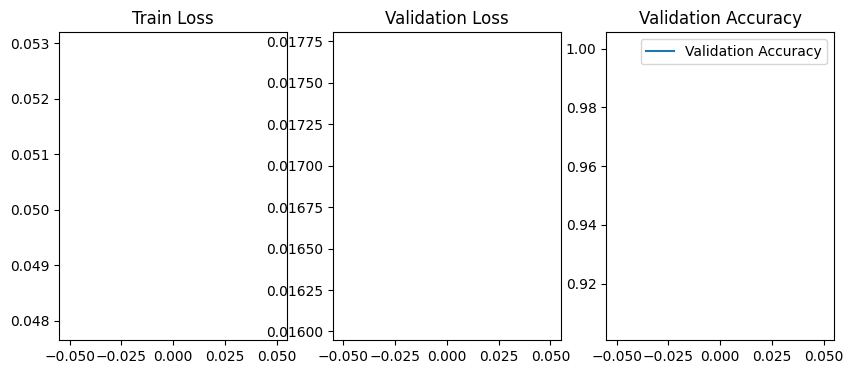

100%|██████████| 1798/1798 [01:58<00:00, 15.13batch/s, loss=0.0065] 


Train loss: 0.017276961356401443
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.00910946709135997
Got 447987852/117800960 with acc 3.80%
Dice score: 0.9539325833320618


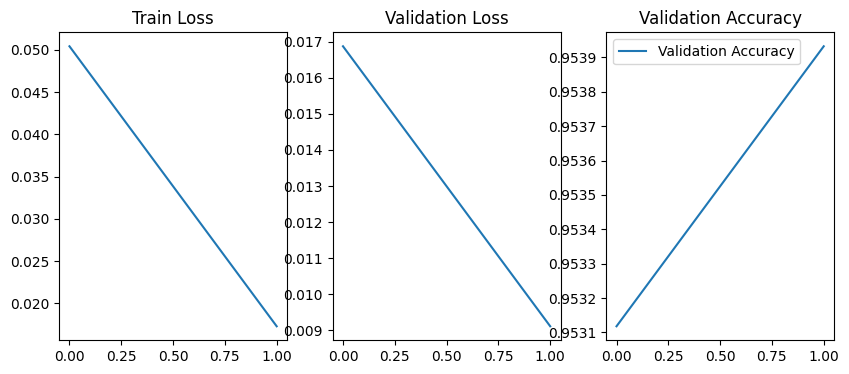

100%|██████████| 1798/1798 [01:58<00:00, 15.12batch/s, loss=0.00434]


Train loss: 0.012338322587311268
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.007613863238393514
Got 448173967/117800960 with acc 3.80%
Dice score: 0.954351007938385


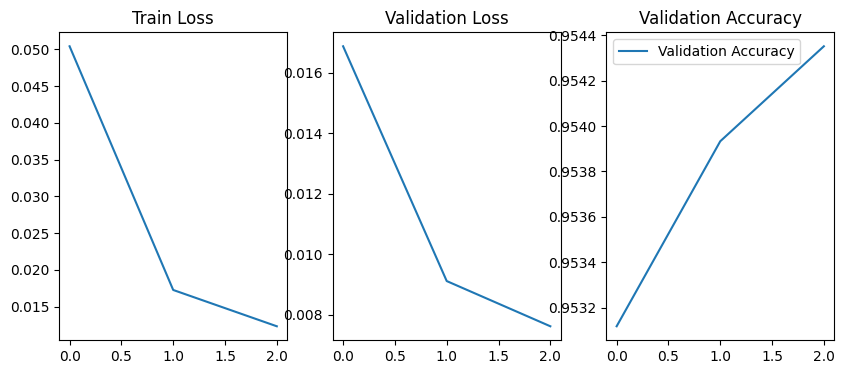

100%|██████████| 1798/1798 [01:58<00:00, 15.12batch/s, loss=0.00535]


Train loss: 0.011130011640489101
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.010954602198049558
Got 447740666/117800960 with acc 3.80%
Dice score: 0.9534323215484619


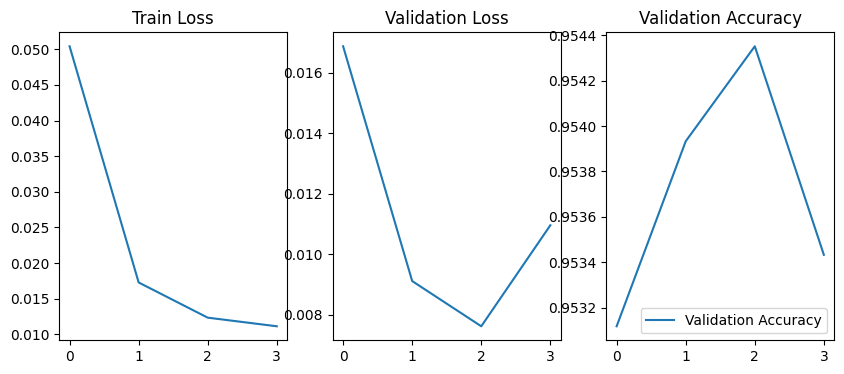

100%|██████████| 1798/1798 [01:58<00:00, 15.13batch/s, loss=0.00471]


Train loss: 0.009653904475271702
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.007535855852231151
Got 448241182/117800960 with acc 3.81%
Dice score: 0.9544900059700012


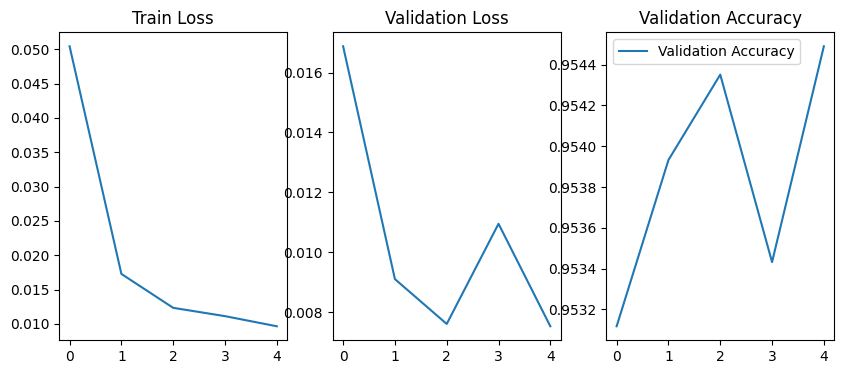

100%|██████████| 1798/1798 [01:58<00:00, 15.14batch/s, loss=0.00801]


Train loss: 0.009470966644585133
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.006470312773989714
Got 448287404/117800960 with acc 3.81%
Dice score: 0.9545823931694031


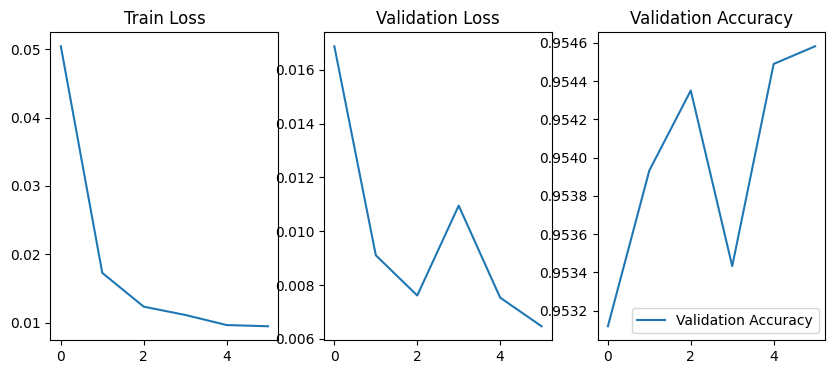

100%|██████████| 1798/1798 [01:59<00:00, 15.10batch/s, loss=0.00315]


Train loss: 0.008112708106637001
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.006483663144926473
Got 448274813/117800960 with acc 3.81%
Dice score: 0.9545351266860962


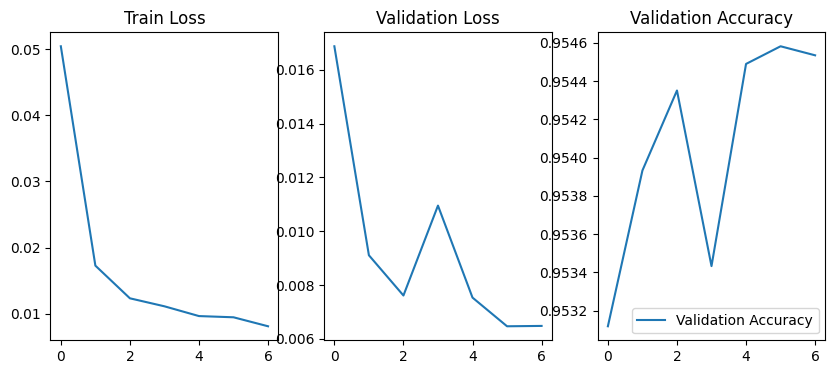

100%|██████████| 1798/1798 [01:58<00:00, 15.16batch/s, loss=0.0116] 


Train loss: 0.008457965217530727
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.006138710823589656
Got 448308368/117800960 with acc 3.81%
Dice score: 0.9546032547950745


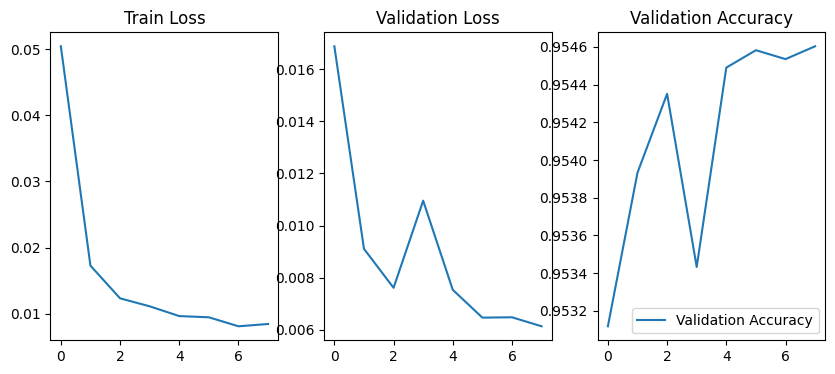

100%|██████████| 1798/1798 [01:58<00:00, 15.16batch/s, loss=0.00424]


Train loss: 0.007734036538749933
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.006196027626288647
Got 448317282/117800960 with acc 3.81%
Dice score: 0.9546473026275635


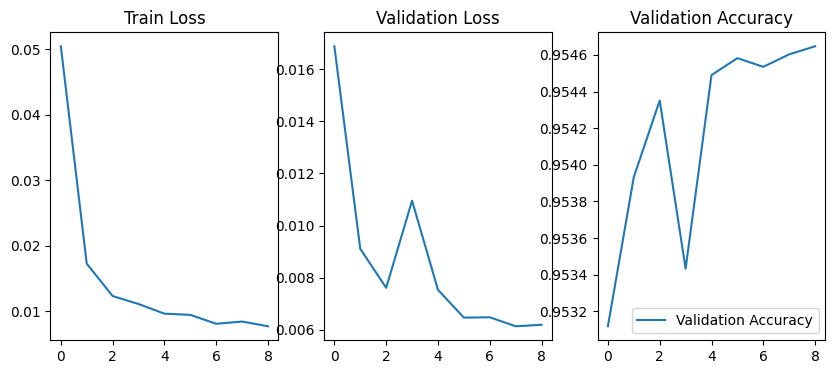

100%|██████████| 1798/1798 [01:58<00:00, 15.16batch/s, loss=0.00865]


Train loss: 0.008463144302368164
=> Saving checkpoint: 
/kaggle/working/Save/my_checkpoint.pth.tar
Val loss: 0.009953714937470994
Got 447942713/117800960 with acc 3.80%
Dice score: 0.9538441896438599


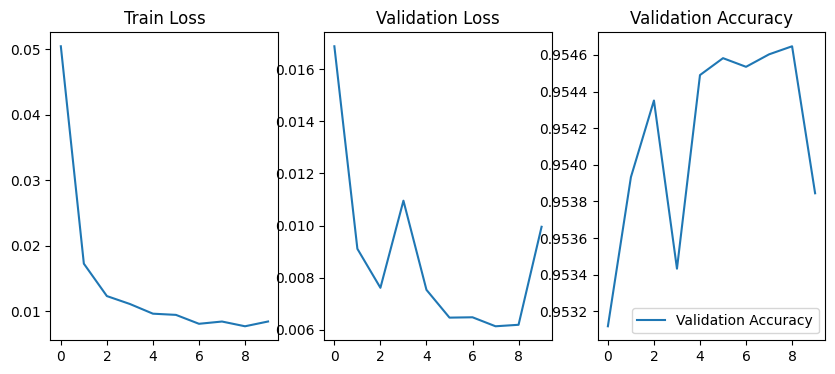

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [144]:
hyper_parameters = HyperParameters(learning_rate=1e-4, batch_size=4, epoch_numbers=10, device='cuda')
run_training(hyper_parameters)

# **Discussion:**
Analyzing my results from the U-Net model's training, The training loss, shown in the terminal output, is at a commendable low of 0.0084, indicating my model is fitting the training data well. Additionally, the validation loss is quite low at 0.0095, which is encouraging as it suggests that my model is generalizing well to new, unseen data.

What's particularly pleasing is the Dice score of 0.95, which is a metric used to gauge the performance of my segmentation model. Given that the Dice score ranges from 0 to 1, where 1 signifies perfect overlap between the predicted and ground-truth segments, a score this close to 1 indicates an excellent segmentation performance.

Upon inspecting the plots, I observe a downward trend in the training loss, suggesting that my model is learning and improving with each epoch. The validation loss plot, however, shows some volatility with spikes at certain epochs. This could be a sign that my model might be sensitive to certain batches of validation data, or perhaps there could be outliers or noise in the validation set affecting the loss calculation.

The validation accuracy graph portrays a different story. It seems to be well-maintained above 0.9532, peaking at 0.9546, which is an outstanding level of accuracy for a segmentation task. However, this plot also exhibits some fluctuations, which makes me think about potential overfitting, or it might be a characteristic of the data or model that requires further investigation, such as batch size or learning rate adjustments.

In conclusion, the overall performance seems quite strong, but the variability in the validation loss and accuracy metrics suggests that I might need to fine-tune the training process to achieve more consistent results across epochs. 

# Evaluation

=> Loading checkpoint
=> Checkpoint loaded successfully
y size : torch.Size([4, 1, 128, 256])
preds size: torch.Size([4, 1, 128, 256])


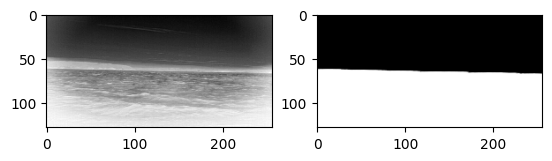

In [24]:
import albumentations as A
import torch

load_checkpoint(torch.load(CHECKPOINT_PATH), model)
val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_ds = HorizonDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transforms
    )

val_loader = DataLoader(
        val_ds,
        batch_size= 4,
        num_workers=2,
        pin_memory=True,
        shuffle=False
)

val_images, val_masks = next(iter(val_loader))

data = val_images
y =model(data)

preds = torch.sigmoid(y)
print(f"y size : {y.size()}")
print(f"preds size: {preds.size()}")

preds = preds.detach().numpy()



f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(val_images[1][0], cmap="gray")
f.add_subplot(1,2, 2)
plt.imshow(preds[1][0], cmap="gray")
plt.show(block=True)



# **Discussion:**
The evaluation output provided how my model is performing on the task of distinguishing between the sea and the sky in an image. The left image represents an input to the model, which appears to be a grayscale image of a horizon where the sea meets the sky. The right image represents the model's prediction of the segmentation between these two classes.

From the predicted segmentation image, I can see a clear demarcation line, which suggests that my model is able to differentiate between the sea and the sky with a high level of confidence. The segmentation is crisp, indicating a strong distinction with little to no ambiguity at the boundary. Therefore the model has learned the relevant features that distinguish between the two classes.

